### Old ver.


In [36]:
import pyrealsense2 as rs
import matplotlib.pyplot as plt 
import numpy as np
import cv2

pipeline = rs.pipeline()    # realsense pipeline open
config = rs.config()        # config class 생성!
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)  # stream 종류, size, format 설정등록
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

profile = pipeline.start(config)   # pipeline start

depth_sensor = profile.get_device().first_depth_sensor()    # depth sensor에 대한 것들을 얻자
depth_scale = depth_sensor.get_depth_scale()                # 깊이 센서의 깊이 스케일 얻음
print("Depth Scale is: ", depth_scale)

clipping_distance_in_meters = 1    # 1 meter, 클리핑할 영역을 1m로 설정
clipping_distance = clipping_distance_in_meters / depth_scale   #스케일에 따른 클리핑 거리

align_to = rs.stream.color      #depth 이미지를 맞추기 위한 이미지, 컬러 이미지
align = rs.align(align_to)      #depth 이미지와 맞추기 위해 align 생성
# Align 시키는 과정 때문에 화곽이 줄어드는 것 

try:
    frames = pipeline.wait_for_frames() #color와 depth의 프레임셋을 기다림
    #frames.get_depth_frame() 은 640x360 depth 이미지이다.

    aligned_frames= align.process(frames)   #모든(depth 포함) 프레임을 컬러 프레임에 맞추어 반환

    aligned_depth_frame = aligned_frames.get_depth_frame()  #  aligned depth 프레임은 640x480 의 depth 이미지이다
    color_frame = aligned_frames.get_color_frame()      #컬러 프레임을 얻음

    # Apply filter to fill the Holes in the depth image
    spatial = rs.spatial_filter()
    spatial.set_option(rs.option.holes_fill, 3)
    filtered_depth = spatial.process(aligned_depth_frame)

    hole_filling = rs.hole_filling_filter()
    filled_depth = hole_filling.process(filtered_depth)


    # Create colormap to show the depth of the Objects
    colorizer = rs.colorizer()
    depth_colormap = np.asanyarray(colorizer.colorize(filled_depth).get_data())


    # Convert images to numpy arrays
    distance = aligned_depth_frame.get_distance(int(50),int(50))
    print("distance", distance)
    depth_image = np.asanyarray(filled_depth.get_data())


    depth_image = np.asanyarray(aligned_depth_frame.get_data())     #depth이미지를 배열로, 
    color_image = np.asanyarray(color_frame.get_data())             #color 이미지를 배열로
    np.save('./data/npy/old_ver.npy' , depth_image)
    #백그라운드 제거
    grey_color = 153
    depth_image_3d = np.dstack((depth_image, depth_image, depth_image))  #depth image는 1채널, 컬러 이미지는 3채널
    bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, color_image)
    # 클리핑 거리를 깊이 _이미지가 넘어서거나, 0보다 적으면, 회색으로 아니면 컬러 이미지로 반환

    #이미지 렌더링
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        # applyColorMap(src, 필터) 필터를 적용함 , COLORMAP_JET=  연속적인 색상, blue -> red
        # convertScaleAbs: 인자적용 후 절대값, 8비트 반환

    images = np.hstack((bg_removed, depth_colormap))  #두 이미지를 수평으로 연결
    cv2.namedWindow('Align Example', cv2.WINDOW_AUTOSIZE)   #이미지 윈도우 정의
    # cv2.imshow('Align Example', images)         #이미지를 넣어 윈도우에 보임
    # np.save("./data/rs_multi_objs_4.npy", images)
finally:
    pipeline.stop()     #리얼센스 데이터 스트리밍 중지


Depth Scale is:  0.0010000000474974513
distance 1.090000033378601


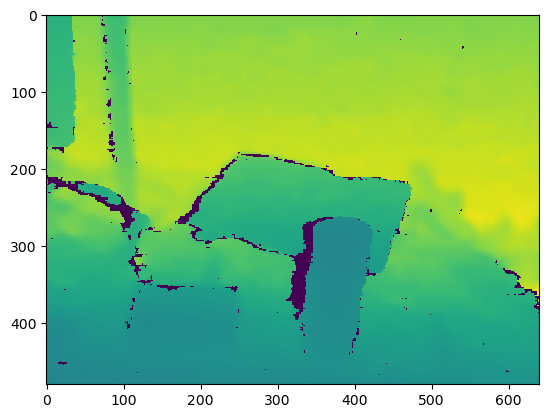

In [37]:
data = np.load('./data/npy/old_ver.npy')
plt.imshow(data)

In [40]:
import pyrealsense2 as rs
import matplotlib.pyplot as plt 
import numpy as np
import cv2

RESHAPE= False
FILTERED= True
img_shape = (320, 240)

pipeline = rs.pipeline() 
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
profile = pipeline.start(config)

depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale() 

clipping_distance_in_meters = 1 
clipping_distance = clipping_distance_in_meters / depth_scale 

# Declare filters
dec_filter = rs.decimation_filter()   # Decimation - reduces depth frame density
spat_filter = rs.spatial_filter()          # Spatial    - edge-preserving spatial smoothing
spat_filter.set_option(rs.option.holes_fill, 3)
temp_filter = rs.temporal_filter()    # Temporal   - reduces temporal noise
hole_filter = rs.hole_filling_filter()
threshold_filter = rs.threshold_filter()

frames = pipeline.wait_for_frames() 
depth_frame = frames.get_depth_frame()

if FILTERED:
    #depth_frame = dec_filter.process(depth_frame)
    depth_frame = spat_filter.process(depth_frame)
    #depth_frame = temp_filter.process(depth_frame)
    depth_frame = hole_filter.process(depth_frame)
    #depth_frame = threshold_filter.process(depth_frame)
else: 
    pass 

data = np.asanyarray(depth_frame.get_data())
if RESHAPE:
    data = cv2.resize(data, img_shape, interpolation=cv2.INTER_CUBIC).astype('float32')
    cv_image_norm = cv2.normalize(data, data, 0, 1, cv2.NORM_MINMAX)
    np.save('./data/npy/pyrealsense_reshaped.npy', cv_image_norm)
    print("[Min Value: {}][Max Vaue: {}]".format(np.min(data), np.max(data)))
    cv2.imshow('Depth Image', cv_image_norm*1)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
else: 
    cv_image_norm = cv2.normalize(data, data, 0, 255, cv2.NORM_MINMAX)
    np.save('./data/npy/pyrealsense.npy', cv_image_norm)
    print("[Min Value: {}][Max Vaue: {}][Average Value:{}]".format(np.min(data), np.max(data), np.average(data)))
    cv2.imshow('Image', cv_image_norm*255)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()


[Min Value: 0][Max Vaue: 255][Average Value:45.77264322916667]


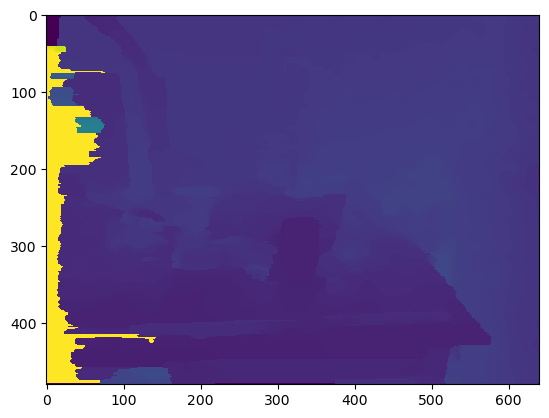

: 

In [41]:
data = np.load('./data/npy/pyrealsense.npy')
plt.imshow(data)